In [11]:
import numpy as np
import lda
import lda.datasets
X = lda.datasets.load_reuters()
vocab = lda.datasets.load_reuters_vocab()
titles = lda.datasets.load_reuters_titles()
X.shape

(395, 4258)

In [12]:
import os, numpy as np
from nltk import word_tokenize, sent_tokenize

all_tokens = set()
biography_tokens = list()
biography_sentences = list()
biography_sentences_tokens = list();

for file in os.listdir("."):
    if file.endswith(".txt"):
        with open(file, 'r') as f:
            raw_biography_text = f.read()
            tokens = word_tokenize(raw_biography_text)
            sentences = sent_tokenize(raw_biography_text)
            biography_tokens.append(tokens)
            all_tokens |= set(tokens)
            
            biography_sentences.append(sentences)
            biography_sentences_tokens.append(list(word_tokenize(sentence) for sentence in sentences))
            
all_tokens_list = list(all_tokens)
number_of_biographies = len(biography_tokens)
number_of_tokens = len(all_tokens_list)
biography_bow = np.zeros([number_of_biographies, number_of_tokens], dtype = np.int)

for i in range(number_of_biographies):
    for j in range(len(biography_tokens[i])):
        biography_bow[i][all_tokens_list.index(biography_tokens[i][j])] += 1

In [13]:
vocab = all_tokens_list
biography_bow.shape

(6, 7125)

In [14]:
number_of_topics = 30

model = lda.LDA(n_topics=number_of_topics, n_iter=1500, random_state=1)
model.fit(biography_bow)  # model.fit_transform(X) is also available

In [20]:
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 20

topics_words = list()

for i, topic_dist in enumerate(topic_word):
    # topic_words: words sorted by relevance to topic in descending order
    topic_words = list(np.array(vocab)[np.argsort(topic_dist)[::-1]])#[:10]#[:-(n_top_words+1):-1]
    #print(topic_words)
    topics_words.append(topic_words)
    print('Topic {}: {} ({})'.format(i, ' '.join(topic_words[:10])+'...',len(topic_words)))

Topic 0: Presley show Parker rock record blues Phillips Sun $ only... (7125)
Topic 1: Carrey vaccination Dumb 1994 Dumber law 1995 stated Christmas McCarthy... (7125)
Topic 2: you hit As now singing By 1967 able before Award... (7125)
Topic 3: ? recorded recalled Love Sullivan broadcast called charts Allen 'd... (7125)
Topic 4: [ ] in and ) ( 's which at is... (7125)
Topic 5: Elvis Memphis country gospel session Moore sang something films Las... (7125)
Topic 6: research ; became Poland scientific 18 daughter 1898 conducted Pasteur... (7125)
Topic 7: performance pop popular do All audience Nashville 1976 King artist... (7125)
Topic 8: her she [ ] Curie She Pierre Paris Marie radium... (7125)
Topic 9: performances Do drug deal ! well lead performing professional magazine... (7125)
Topic 10: number studio one RCA shows Vegas sound played chart black... (7125)
Topic 11: to the had from first were it an would be... (7125)
Topic 12: Armstrong the his mission Moon flew pilot Gemini surface NA

In [21]:
def calculate_word_topic_id(word, topics_words):
    topic_id = -1
    min_topic_index = number_of_tokens + 1
    for current_topic_id in range(number_of_topics):
        index = topics_words[current_topic_id].index(word)
        if index < min_topic_index:
            topic_id = current_topic_id
            min_topic_index = index
            
    return topic_id

In [22]:
 calculate_word_topic_id("Elvis", topics_words)

5

In [23]:
def calculate_vocabulary_topic_ids(vocabulary, topics_words):
    topic_ids = list()
    for word in vocab:
        topic_ids.append(calculate_word_topic_id(word, topics_words))
        
    return topic_ids

In [24]:
vocabulary_topic_ids = calculate_vocabulary_topic_ids(vocab, topics_words)

In [25]:
def get_vocabulary_word_topic_id(vocabulary, vocabulary_topic_ids, word):
    return vocabulary_topic_ids[vocabulary.index(word)]

In [26]:
get_vocabulary_word_topic_id(vocab, vocabulary_topic_ids, "Elvis")

5

In [27]:
#biography_sentences_tokens

def get_sentence_topic_ids(sentence, topics_words):
    topic_ids = list()
    for word in sentence:
        topic_ids.append(get_vocabulary_word_topic_id(vocab, vocabulary_topic_ids, word))
        
    return topic_ids

In [28]:
#get_sentence_topic_ids(biography_sentences_tokens[1][0], topics_words)

In [29]:
def get_sentences_topic_ids(sentences, topic_words):
    topic_ids = list()
    for sentence in sentences:
        topic_ids.append(get_sentence_topic_ids(sentence, topics_words))
        
    return topic_ids

In [30]:
sentences_topic_ids = get_sentences_topic_ids(biography_sentences_tokens[0], topic_words)

In [31]:
def get_biography_sentences_topic_ids(biography_sentences_tokens, topic_words):
    biography_sentences_topic_ids = list()
    for sentences in biography_sentences_tokens:
        biography_sentences_topic_ids.append(get_sentences_topic_ids(sentences, topic_words))
    
    return biography_sentences_topic_ids

In [32]:
biography_sentences_topic_ids = get_biography_sentences_topic_ids(biography_sentences_tokens, topic_words)

In [33]:
def calculate_sentence_topics_frequency(sentence_topic_ids, number_of_topics):
    topics_frequencies = np.zeros(number_of_topics)
    for topic_id in sentence_topic_ids:
        topics_frequencies[topic_id] += 1
    
    return topics_frequencies

In [34]:
def calculate_sentences_topics_frequency(sentences_topic_ids, number_of_topics):
    sentences_topics_frequencies = list()
    for sentence in sentences_topic_ids:
        sentences_topics_frequencies.append(calculate_sentence_topics_frequency(sentence, number_of_topics))
        
    return sentences_topics_frequencies

In [35]:
def calculate_biography_sentences_topics_frequencies(biography_sentences_topic_ids, number_of_topics):
    biography_sentences_topics_frequencies = list()
    for sentences in biography_sentences_topic_ids:
        biography_sentences_topics_frequencies.append(calculate_sentences_topics_frequency(sentences, number_of_topics))
        
    return biography_sentences_topics_frequencies

In [36]:
biography_sentences_topics_frequencies = calculate_biography_sentences_topics_frequencies(biography_sentences_topic_ids, number_of_topics)

In [37]:
#biography_sentences_topics_frequencies

In [38]:
def calculate_coherence_score(sentences_topics_frequencies, number_of_topics, position, window_size):
    pre_topics_frequencies = np.zeros(number_of_topics)
    for i in range(window_size):
        pre_topics_frequencies += sentences_topics_frequencies[position - i]
        
    post_topics_frequencies = np.zeros(number_of_topics)
    for i in range(window_size):
        post_topics_frequencies += sentences_topics_frequencies[position + 1 + i]
        
    dot_product = np.dot(pre_topics_frequencies, post_topics_frequencies)
    pre_norm = np.linalg.norm(pre_topics_frequencies)
    post_norm = np.linalg.norm(post_topics_frequencies)
    
    cosine_similarity = dot_product / (pre_norm * post_norm)
    
    return cosine_similarity

In [39]:
calculate_coherence_score(biography_sentences_topics_frequencies[0], number_of_topics, 65, 3)

0.82138298287197387

In [40]:
def calculate_coherence_scores(sentences_topics_frequencies, number_of_topics, window_size):
    coherence_scores = list()
    for i in range(len(sentences_topics_frequencies) - 2 * window_size):
        score = calculate_coherence_score(sentences_topics_frequencies, number_of_topics, window_size + i - 1, window_size)
        coherence_scores.append(score)
        
    return coherence_scores

In [41]:
def calculate_depth_scores(coherence_scores):
    depth_scores = list()
    for i in range(len(coherence_scores)):
        hl = coherence_scores[i]
        hr = coherence_scores[i]
        for j in range(i):
            if coherence_scores[j] > coherence_scores[i]:
                hl = coherence_scores[j]
            else:
                break
        
        for j in range(i + 1, len(coherence_scores)):
            if coherence_scores[j] > coherence_scores[i]:
                hr = coherence_scores[j]
            else:
                break
                
        depth_score = 0.5 * (hl + hr - 2 * coherence_scores[i])
        depth_scores.append(depth_score)
        
    return depth_scores

In [42]:
coherence_scores = calculate_coherence_scores(biography_sentences_topics_frequencies[0], number_of_topics, 3)

In [43]:
depth_scores = calculate_depth_scores(coherence_scores)

In [44]:
mean = np.mean(depth_scores)

In [45]:
std = np.std(depth_scores)

In [46]:
mean - std /2

-0.00054664782276359937

In [47]:
#depth_scores

In [48]:
len(depth_scores)

272

In [49]:
len(biography_sentences_topics_frequencies[0])

278

In [50]:
biography_sentences[0][:10]

['Neil Alden Armstrong (August 5, 1930 – August 25, 2012) was an American astronaut and the first person to walk on the Moon.',
 'He was also an aerospace engineer, naval aviator, test pilot, and university professor.',
 'Before becoming an astronaut, Armstrong was an officer in the U.S. Navy and served in the Korean War.',
 "After the war, he earned his bachelor's degree at Purdue University and served as a test pilot at the National Advisory Committee for Aeronautics(NACA) High-Speed Flight Station, where he logged over 900 flights.",
 'He later completed graduate studies at theUniversity of Southern California.',
 "A participant in the U.S. Air Force's Man in Space Soonest and X-20 Dyna-Soar human spaceflight programs, Armstrong joined the NASA Astronaut Corps in 1962.",
 "He made his first space flight as command pilot of Gemini 8 in March 1966, becoming NASA's first civilian astronaut to fly in space.",
 'He performed the first docking of two spacecraft, with pilot David Scott.',


In [51]:
biography_sentences[1][:10]

['James Eugene "Jim" Carrey (/ˈkæri/; born January 17, 1962)[3] is a Canadian American actor, comedian, impressionist, screenwriter, and film producer.',
 'He is known for his highly energetic slapstick performances.',
 '[4]\nCarrey first gained recognition in 1990 after landing a recurring role in the sketch comedy In Living Color.',
 'His first leading roles in major productions came with Ace Ventura: Pet Detective (1994), Dumb and Dumber (1994), The Mask (1994), and Ace Ventura: When Nature Calls (1995), as well as a supporting role in Batman Forever (1995) and a lead role in Liar Liar (1997).',
 'He then starred in The Truman Show (1998) and Man on the Moon (1999), with each garnering him a Golden Globe Award for Best Actor.',
 "In the 2000s, he gained further recognition for his portrayal of the Grinch in How the Grinch Stole Christmas (2000), as well as Bruce Almighty (2003), Eternal Sunshine of the Spotless Mind (2004), Lemony Snicket's A Series of Unfortunate Events (2004), Fun

In [52]:
%matplotlib inline
import pickle,pandas
import matplotlib.pyplot as plt
import numpy as np
bios = pandas.read_pickle('../paragraphs_by_articles.pickle')
lengths = pandas.DataFrame([{'length' : len(x)} for x in bios])
lengths.describe()

,length
count,6045.00000
mean,9.70306
std,8.17271
min,0.00000
25%,5.00000
50%,7.00000
75%,12.00000
max,102.00000


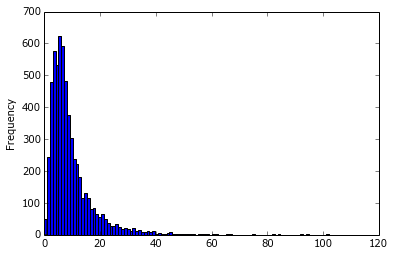

In [53]:
lengths.length.plot(bins=100, kind='hist')
plt.show()

So we can set the number of divisions for tiling at 25 or so. I guess the number of topics for LDA should be around that ball park too. So we can keep it at 30.

In [56]:
condenced_bios = [" ".join([part[1] for part in bio]) for bio in bios]
condenced_bios[5]

"Duane Ackerson (born 1942) is an American writer of speculative poetry and fiction. He currently lives in Salem, Oregon.\nDuane Ackerson's work has appeared in anthologies that include The Year's Best SF 1974, 100 Great Science Fiction Short Short Stories, Future Pastimes, and the textbook Writing Poetry. He has won the Rhysling Award for Best Short Poem twice, in 1978 and 1979. The Bird at the End of the Universe\nThe Eggplant & Other Absurdities\nWeathering\nUA Flight to Chicago. Lincoln, Nebraska: The Best Cellar Press, 1971.  Duane Ackerson at the Internet Speculative Fiction Database"

In [70]:
import sys
def progress(i, end_val, bar_length=50):
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
all_tokens = set()
biography_tokens = list()
biography_sentences = list()
biography_sentences_tokens = list();
print("getting tokens") 
for ind,bio in enumerate(condenced_bios[:500]):
    tokens = word_tokenize(bio)
    sentences = sent_tokenize(bio)
    biography_tokens.append(tokens)
    all_tokens |= set(tokens)
    biography_sentences.append(sentences)
    biography_sentences_tokens.append(list(word_tokenize(sentence) for sentence in sentences))
    progress(ind+1,500)
            
all_tokens_list = list(all_tokens)
number_of_biographies = len(biography_tokens)
number_of_tokens = len(all_tokens_list)
biography_bow = np.zeros([number_of_biographies, number_of_tokens], dtype = np.int)

print("\n", "creating bow")
for i in range(number_of_biographies):
    for j in range(len(biography_tokens[i])):
        biography_bow[i][all_tokens_list.index(biography_tokens[i][j])] += 1
    progress(i+1,number_of_biographies)
vocab = all_tokens_list
biography_bow.shape

getting tokens
Percent: [##################################################] 100%
 creating bow
Percent: [##################################################] 100%

(500, 49548)

In [71]:
number_of_topics = 30
model = lda.LDA(n_topics=number_of_topics, n_iter=1500, random_state=1)
%time model.fit(biography_bow)  # model.fit_transform(X) is also available

CPU times: user 7min 33s, sys: 156 ms, total: 7min 33s
Wall time: 7min 32s


In [72]:
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 20

topics_words = list()

for i, topic_dist in enumerate(topic_word):
    # topic_words: words sorted by relevance to topic in descending order
    topic_words = list(np.array(vocab)[np.argsort(topic_dist)[::-1]])#[:10]#[:-(n_top_words+1):-1]
    #print(topic_words)
    topics_words.append(topic_words)
    print('Topic {}: {}'.format(i, ' '.join(topic_words[:10])+'...'))

Topic 0: , ) ( . of the and in The a...
Topic 1: : Cisneros her Carver Fulton she By de `` Raymond...
Topic 2: the , . of and to a in as ''...
Topic 3: , : Press with Poetry & New poems University Books...
Topic 4: : Brodsky – Poems ( Volume Louis Faulkner * =...
Topic 5: Adams Emerson Alcott Grimké John Boston May Massachusetts ISBN Waldo...
Topic 6: '' , `` of 's The poetry poems : work...
Topic 7: , Eliot New Poems York poetry : poet Frost Harvard...
Topic 8: . , : by New Edited York The Brennan Fiction...
Topic 9: , his was . he in a He to at...
Topic 10: . , : Press California San Angeles Black Bukowski Los...
Topic 11: New Mexico Angelou state The Indian is Alexie Native %...
Topic 12: : Brautigan http Agee de ISBN San Acosta Ghigna Guenther...
Topic 13: , the and in of . a is has on...
Topic 14: , . : University Poetry Press of the Award for...
Topic 15: is AI are human Eiseley be intelligence : ) or...
Topic 16: the Buck Allen ! Hall 's for season Cardinals baseball...
Topic 17

In [75]:
with open('topics_500.pkl','wb') as topics:
    pickle.dump(topic_word,topics)

In [76]:
test = pickle.load(open('topics_500.pkl','rb'))
test[0]

array([  8.01458783e-08,   2.41239094e-05,   8.01458783e-08, ...,
         8.01458783e-08,   8.01458783e-08,   8.01458783e-08])